In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Distributions
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations
using Statistics
using Memento
using NPZ
# using Interpolations
atype=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32, N} where N

In [2]:
const F = Float32
params = Knet.params

params (generic function with 2 methods)

In [3]:
logger = Memento.config!("info"; fmt="[{date} | {level} | {name}]: {msg}");

In [4]:
include("PlotUtility.jl")
include("ImageUtility.jl")
include("TrainUtility.jl")
include("LayerUtility.jl")
include("LossUtility.jl")

using .PlotUtility
using .ImageUtility
using .TrainUtility
using .LayerUtility
using .LossUtility

In [5]:
dataset_name = "mnist"
notebook_name = "GON_Autoencoder_w_BN_exp2" * "_" * dataset_name

if !isdir("Results")
   mkdir("Results") 
end
if  !isdir(joinpath("Results", notebook_name))
    mkdir(joinpath("Results", notebook_name))
end

if  !isdir(joinpath("Results", notebook_name, "Saved_Models"))
    mkdir(joinpath("Results", notebook_name, "Saved_Models"))
end

if  !isdir(joinpath("Results", notebook_name, "Images"))
    mkdir(joinpath("Results", notebook_name, "Images"))
end

if  !isdir(joinpath("Results", notebook_name, "Logger"))
    mkdir(joinpath("Results", notebook_name, "Logger"))
end

"Results/GON_Autoencoder_w_BN_exp2_mnist/Logger"

In [6]:
push!(logger, DefaultHandler(joinpath("Results", notebook_name, "Logger", "logger.log"),DefaultFormatter("[{date} | {level} | {name}]: {msg}")));

In [7]:
use_saved_data = true

if dataset_name == "mnist"
    
    if use_saved_data
        xtrn = npzread("Data/MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))

    else

        xtrn,_ = MNIST.traindata()
        xtst,_ = MNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)
        
    end
    
elseif dataset_name == "fashion"
    
    if use_saved_data

        xtrn = npzread("Data/Fashion_MNIST_Train_Images.npy")
        xtrn = permutedims(xtrn, (3,4,2,1))
        xtst = npzread("Data/Fashion_MNIST_Test_Images.npy")
        xtst = permutedims(xtst, (3,4,2,1))
        
    else
        
        xtrn,_ = FashionMNIST.traindata()
        xtst,_ = FashionMNIST.testdata()
        xtrn = Array{Float64, 3}(xtrn)
        xtst = Array{Float64, 3}(xtst)

        xtrn = resize_MNIST(xtrn, 32/28)
        xtst = resize_MNIST(xtst, 32/28)

    end
end

batch_size = 64

dtrn = minibatch(xtrn, batch_size; xsize = (32, 32, 1,:), xtype = atype, shuffle = true)
dtst = minibatch(xtst, batch_size; xsize = (32, 32, 1,:), xtype = atype);

,,,,,,,,,

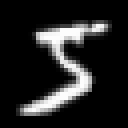
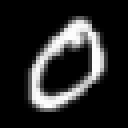
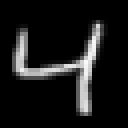
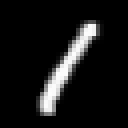
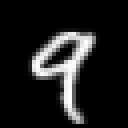
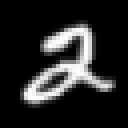
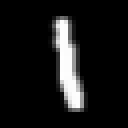
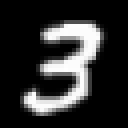
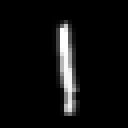
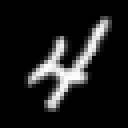

In [8]:
k = 1:10
if use_saved_data
    [Matrix{Gray{Float32}}(reshape(xtrn[:,:,:,j], (32, 32))) for j in k]
else
    [Matrix{Gray{Float32}}(reshape(xtrn[:,:,j], (32, 32))) for j in k]
end

In [9]:
function weights(nc, nz,  ngf) 
        
    # Decoding Weights
    theta = [] # z -> x
    
    w, b = deconv_weight_init(4, 4, nz, ngf * 4;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 4))) # Batch Normalization
    
    w, b = deconv_weight_init(4, 4, ngf * 4, ngf * 2;bias= true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf * 2)))
    
    w, b = deconv_weight_init(4, 4, ngf * 2, ngf;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)
    push!(theta, (bnparams(ngf)))
    
    w,b = deconv_weight_init(4,4,ngf, nc;bias = true, return_param = false)
    push!(theta, w)
    push!(theta, b)

    theta = map(a->convert(atype,a), theta)
    
    return Param.(theta)
end

weights (generic function with 1 method)

In [10]:
moments1 = bnmoments()
moments2 = bnmoments()
moments3 = bnmoments()

function decode(theta, z; batch_size = 64, training = true)
    
    z = deconv4(theta[1], z, mode = 1) .+ theta[2]
    z = mybatchnorm(z, moments1, theta[3]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[4], z, mode = 1, stride = 2, padding = 1) .+ theta[5]
    z = mybatchnorm(z, moments2, theta[6]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[7], z, mode = 1, stride = 2, padding = 1) .+ theta[8]
    z = mybatchnorm(z, moments3, theta[9]; training = training)
    z = Knet.elu.(z)
    
    z = deconv4(theta[10], z, mode = 1, stride = 2, padding = 1) .+ theta[11]
    x_hat = Knet.sigm.(z)
    return x_hat
    
end

function decode_train(theta, x; batch_size = 64)
    origin = Param(atype(zeros(1, 1, nz, batch_size)))
    derivative_origin = @diff inner_loss(x,origin)
    dz = grad(derivative_origin, origin)
    z = -dz
    x_hat = decode(theta, z; batch_size = batch_size, training = true)
    return x_hat
end

# (Reconstruction Error := Mean Squared Error)
inner_loss(x, z) = mean(sum((decode(theta, z; batch_size = size(x,4)) - x).^2, dims = 3))

function loss_train(theta, x)
    x_hat =  decode_train(theta, x; batch_size = size(x,4))
    L = mean(sum((x_hat - x).^2, dims = 3))
end

function loss_train(theta, d::Data)
    total_loss = 0
    n_instance = 0
    for x in d
        total_loss += loss_train(theta, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end

## Sum Squared Error Definition
# function rec_loss(theta, x)
#     x_hat =  decode_train(theta, x; batch_size = size(x,4))
#     x_hat = (floor.(x_hat * 255))./255
#     L = sum((x - x_hat).^2) / size(x,4)
# end

# Sum Squared Error Definition
rec_loss(theta, x) = sum((x - decode_train(theta, x; batch_size = size(x,4))).^2) / size(x,4)

function rec_loss(theta, d::Data)
    total_loss = 0
    n_instance = 0
    for x in d
        total_loss += rec_loss(theta, x) * size(x,4)
        n_instance += size(x,4)
    end
    
    total_loss /= n_instance
end

rec_loss (generic function with 2 methods)

In [11]:
nz = 48
ngf = 32
nc = 1

# first batch of the test dataset
x_test_first = first(dtrn);

# define model weights
theta = weights(nc, nz,  ngf);

# Define Learning Rate and Number of Epochs
lr = 1e-4
n_epochs = 500

# Initialize Empty Lists for both training and test losses
trn_loss_list = Float64[]
tst_loss_list = Float64[]
trn_rec_loss_list = Float64[]
tst_rec_loss_list = Float64[]

# RECORD INITIAL LOSS VALUES
epoch_loss_trn_ = loss_train(theta, dtrn)
epoch_loss_tst_ = loss_train(theta, dtst)
epoch_rec_loss_trn_ = rec_loss(theta, dtrn)
epoch_rec_loss_tst_ = rec_loss(theta, dtst)

push!(trn_loss_list, epoch_loss_trn_)
push!(tst_loss_list, epoch_loss_tst_)
push!(trn_rec_loss_list, epoch_rec_loss_trn_)
push!(tst_rec_loss_list, epoch_rec_loss_tst_)

# println("Epoch : ", 0)
# println("Train Loss : ",epoch_loss_trn_)
# println("Test Loss : ", epoch_loss_tst_)
# println("Train Reconstruction Loss : ", epoch_rec_loss_trn_)
# println("Test Reconstruction Loss : ", epoch_rec_loss_tst_)

info(logger, ("Epoch : 0"))
info(logger, ("Train Loss : $epoch_loss_trn_"))
info(logger, ("Test Loss : $epoch_loss_tst_"))
info(logger, ("Train Reconstruction Loss : $epoch_rec_loss_trn_"))
info(logger, ("Test Reconstruction Loss : $epoch_rec_loss_tst_ \n"))

# Define the step number of model save checkpoint
model_save_checkpoint = 50
logger_checkpoint = 5
image_rec_checkpoint = 25

# Training Loop
for epoch in progress(1:n_epochs)
    for (i,x) in enumerate(dtrn)
        
        derivative_model = @diff loss_train(theta, x)
        
        for p in theta
            dp = grad(derivative_model, p)
            update!(value(p), dp, Knet.Adam(lr = lr, beta1 = 0.9, beta2 = 0.999))
        end

    end
    
    epoch_loss_trn = loss_train(theta, dtrn)
    epoch_loss_tst = loss_train(theta, dtst)
    epoch_rec_loss_trn = rec_loss(theta, dtrn)
    epoch_rec_loss_tst = rec_loss(theta, dtst)
    
    push!(trn_loss_list, epoch_loss_trn)
    push!(tst_loss_list, epoch_loss_tst)
    push!(trn_rec_loss_list, epoch_rec_loss_trn)
    push!(tst_rec_loss_list, epoch_rec_loss_tst)
    
#     println("Epoch : ", epoch)
#     println("Train Loss : ",epoch_loss_trn)
#     println("Test Loss : ", epoch_loss_tst)
#     println("Train Reconstruction Loss : ", epoch_rec_loss_trn)
#     println("Test Reconstruction Loss : ", epoch_rec_loss_tst)
    
    # Print losses to the logger file
    if epoch % logger_checkpoint == 0
        info(logger,"Epoch : $epoch")
        info(logger,"Train Loss : $epoch_loss_trn")
        info(logger,"Test Loss : $epoch_loss_tst")
        info(logger,"Train Reconstruction Loss : $epoch_rec_loss_trn")
        info(logger,"Test Reconstruction Loss : $epoch_rec_loss_tst \n")
    end
    
    # Plot some reconstruction images
    if ((epoch - 1) % image_rec_checkpoint == 0) || (epoch == n_epochs)
        x_test_first_hat = decode_train(theta, x_test_first)
        plot_reconstructed_images(x_test_first, x_test_first_hat, 10, batch_size, (900,300))
        fig_name = "Reconstructed_Imgs_ID" * string(1000 + epoch) 
        savefig(joinpath("Results", notebook_name, "Images", fig_name))
    end
    
    # Save model at some steps
    if (epoch % model_save_checkpoint == 0) || (epoch == n_epochs)
        
        model_id = 1000 + epoch
        model_name = joinpath("Results", notebook_name, "Saved_Models","Model_Base$model_id.jld2")
        w = Dict(:decoder => theta)
        Knet.save(model_name,"model",w) 
        ### TO LOAD THE MODEL WEIGHTS, USE THE FOLLOWING
        # w = Knet.load(model_name,"model",) # Ex: model_name = "Results/Conv_AutoEncoder_Baseline_MNIST/Saved_Models/Model_Base1500.jld2"
        # theta = w[:decoder]
        
    end
    
end

[2021-12-08 13:33:46 | info | root]: Epoch : 0
[2021-12-08 13:33:46 | info | root]: Train Loss : 0.23333599
[2021-12-08 13:33:46 | info | root]: Test Loss : 0.23341976
[2021-12-08 13:33:46 | info | root]: Train Reconstruction Loss : 237.56425
[2021-12-08 13:33:46 | info | root]: Test Reconstruction Loss : 237.6555 



┣▏                   ┫ [1.00%, 5/500, 02:09/03:34:44, 25.19s/i] 

[2021-12-08 13:36:21 | info | root]: Epoch : 5
[2021-12-08 13:36:21 | info | root]: Train Loss : 0.0028015396
[2021-12-08 13:36:21 | info | root]: Test Loss : 0.0031562932
[2021-12-08 13:36:21 | info | root]: Train Reconstruction Loss : 2.8552864
[2021-12-08 13:36:21 | info | root]: Test Reconstruction Loss : 3.2226336 



┣▍                   ┫ [2.00%, 10/500, 04:14/03:32:05, 25.22s/i] 

[2021-12-08 13:38:27 | info | root]: Epoch : 10
[2021-12-08 13:38:27 | info | root]: Train Loss : 0.002306774
[2021-12-08 13:38:27 | info | root]: Test Loss : 0.0025737735
[2021-12-08 13:38:27 | info | root]: Train Reconstruction Loss : 2.350961
[2021-12-08 13:38:27 | info | root]: Test Reconstruction Loss : 2.6288424 



┣▌                   ┫ [3.00%, 15/500, 06:22/03:32:02, 25.43s/i] 

[2021-12-08 13:40:34 | info | root]: Epoch : 15
[2021-12-08 13:40:34 | info | root]: Train Loss : 0.0020279728
[2021-12-08 13:40:34 | info | root]: Test Loss : 0.0022579178
[2021-12-08 13:40:34 | info | root]: Train Reconstruction Loss : 2.0701299
[2021-12-08 13:40:34 | info | root]: Test Reconstruction Loss : 2.3070703 



┣▊                   ┫ [4.00%, 20/500, 08:29/03:32:02, 25.41s/i] 

[2021-12-08 13:42:41 | info | root]: Epoch : 20
[2021-12-08 13:42:41 | info | root]: Train Loss : 0.0019304843
[2021-12-08 13:42:41 | info | root]: Test Loss : 0.0021071604
[2021-12-08 13:42:41 | info | root]: Train Reconstruction Loss : 1.9646951
[2021-12-08 13:42:41 | info | root]: Test Reconstruction Loss : 2.1475968 



┣█                   ┫ [5.00%, 25/500, 10:37/03:32:23, 25.72s/i] 

[2021-12-08 13:44:50 | info | root]: Epoch : 25
[2021-12-08 13:44:50 | info | root]: Train Loss : 0.0018002647
[2021-12-08 13:44:50 | info | root]: Test Loss : 0.0019997007
[2021-12-08 13:44:50 | info | root]: Train Reconstruction Loss : 1.8331022
[2021-12-08 13:44:50 | info | root]: Test Reconstruction Loss : 2.0402548 



┣█▏                  ┫ [6.00%, 30/500, 12:46/03:32:52, 25.87s/i] 

[2021-12-08 13:46:59 | info | root]: Epoch : 30
[2021-12-08 13:46:59 | info | root]: Train Loss : 0.0017336771
[2021-12-08 13:46:59 | info | root]: Test Loss : 0.001934351
[2021-12-08 13:46:59 | info | root]: Train Reconstruction Loss : 1.7701766
[2021-12-08 13:46:59 | info | root]: Test Reconstruction Loss : 1.9782498 



┣█▍                  ┫ [7.00%, 35/500, 14:55/03:33:09, 25.74s/i] 

[2021-12-08 13:49:08 | info | root]: Epoch : 35
[2021-12-08 13:49:08 | info | root]: Train Loss : 0.001696955
[2021-12-08 13:49:08 | info | root]: Test Loss : 0.0018789308
[2021-12-08 13:49:08 | info | root]: Train Reconstruction Loss : 1.7361822
[2021-12-08 13:49:08 | info | root]: Test Reconstruction Loss : 1.925624 



┣█▌                  ┫ [8.00%, 40/500, 17:05/03:33:30, 25.93s/i] 

[2021-12-08 13:51:18 | info | root]: Epoch : 40
[2021-12-08 13:51:18 | info | root]: Train Loss : 0.0016235166
[2021-12-08 13:51:18 | info | root]: Test Loss : 0.0017875242
[2021-12-08 13:51:18 | info | root]: Train Reconstruction Loss : 1.6564171
[2021-12-08 13:51:18 | info | root]: Test Reconstruction Loss : 1.8273994 



┣█▊                  ┫ [9.00%, 45/500, 19:15/03:33:55, 26.04s/i] 

[2021-12-08 13:53:28 | info | root]: Epoch : 45
[2021-12-08 13:53:28 | info | root]: Train Loss : 0.0015836885
[2021-12-08 13:53:28 | info | root]: Test Loss : 0.0017675007
[2021-12-08 13:53:28 | info | root]: Train Reconstruction Loss : 1.6159059
[2021-12-08 13:53:28 | info | root]: Test Reconstruction Loss : 1.8070191 



┣██                  ┫ [10.00%, 50/500, 21:25/03:34:09, 26.13s/i] 

[2021-12-08 13:55:38 | info | root]: Epoch : 50
[2021-12-08 13:55:38 | info | root]: Train Loss : 0.0015260987
[2021-12-08 13:55:38 | info | root]: Test Loss : 0.0017062277
[2021-12-08 13:55:38 | info | root]: Train Reconstruction Loss : 1.5588906
[2021-12-08 13:55:38 | info | root]: Test Reconstruction Loss : 1.7457312 



┣██▏                 ┫ [11.00%, 55/500, 23:53/03:37:05, 26.06s/i] 

[2021-12-08 13:58:06 | info | root]: Epoch : 55
[2021-12-08 13:58:06 | info | root]: Train Loss : 0.0015076873
[2021-12-08 13:58:06 | info | root]: Test Loss : 0.0016902629
[2021-12-08 13:58:06 | info | root]: Train Reconstruction Loss : 1.5361449
[2021-12-08 13:58:06 | info | root]: Test Reconstruction Loss : 1.7269553 



┣██▍                 ┫ [12.00%, 60/500, 26:03/03:37:08, 26.11s/i] 

[2021-12-08 14:00:17 | info | root]: Epoch : 60
[2021-12-08 14:00:17 | info | root]: Train Loss : 0.0014545561
[2021-12-08 14:00:17 | info | root]: Test Loss : 0.0016299585
[2021-12-08 14:00:17 | info | root]: Train Reconstruction Loss : 1.4869009
[2021-12-08 14:00:17 | info | root]: Test Reconstruction Loss : 1.6685891 



┣██▌                 ┫ [13.00%, 65/500, 28:14/03:37:14, 26.35s/i] 

[2021-12-08 14:02:28 | info | root]: Epoch : 65
[2021-12-08 14:02:28 | info | root]: Train Loss : 0.0014397765
[2021-12-08 14:02:28 | info | root]: Test Loss : 0.0016178525
[2021-12-08 14:02:28 | info | root]: Train Reconstruction Loss : 1.4798094
[2021-12-08 14:02:28 | info | root]: Test Reconstruction Loss : 1.6648425 



┣██▊                 ┫ [14.00%, 70/500, 30:26/03:37:22, 26.40s/i] 

[2021-12-08 14:04:39 | info | root]: Epoch : 70
[2021-12-08 14:04:39 | info | root]: Train Loss : 0.0014120041
[2021-12-08 14:04:39 | info | root]: Test Loss : 0.001580616
[2021-12-08 14:04:39 | info | root]: Train Reconstruction Loss : 1.4488423
[2021-12-08 14:04:39 | info | root]: Test Reconstruction Loss : 1.6232765 



┣███                 ┫ [15.00%, 75/500, 32:37/03:37:30, 26.45s/i] 

[2021-12-08 14:06:51 | info | root]: Epoch : 75
[2021-12-08 14:06:51 | info | root]: Train Loss : 0.0014007582
[2021-12-08 14:06:51 | info | root]: Test Loss : 0.0015831612
[2021-12-08 14:06:51 | info | root]: Train Reconstruction Loss : 1.4378512
[2021-12-08 14:06:51 | info | root]: Test Reconstruction Loss : 1.6287436 



┣███▏                ┫ [16.00%, 80/500, 34:51/03:37:49, 27.58s/i] 

[2021-12-08 14:09:05 | info | root]: Epoch : 80
[2021-12-08 14:09:05 | info | root]: Train Loss : 0.001387015
[2021-12-08 14:09:05 | info | root]: Test Loss : 0.0015364039
[2021-12-08 14:09:05 | info | root]: Train Reconstruction Loss : 1.4116788
[2021-12-08 14:09:05 | info | root]: Test Reconstruction Loss : 1.567288 



┣███▍                ┫ [17.00%, 85/500, 37:03/03:37:54, 26.41s/i] 

[2021-12-08 14:11:16 | info | root]: Epoch : 85
[2021-12-08 14:11:16 | info | root]: Train Loss : 0.0013563153
[2021-12-08 14:11:16 | info | root]: Test Loss : 0.0015160162
[2021-12-08 14:11:16 | info | root]: Train Reconstruction Loss : 1.3876318
[2021-12-08 14:11:16 | info | root]: Test Reconstruction Loss : 1.554077 



┣███▌                ┫ [18.00%, 90/500, 39:14/03:37:58, 26.56s/i] 

[2021-12-08 14:13:27 | info | root]: Epoch : 90
[2021-12-08 14:13:27 | info | root]: Train Loss : 0.0013512019
[2021-12-08 14:13:27 | info | root]: Test Loss : 0.0015243207
[2021-12-08 14:13:27 | info | root]: Train Reconstruction Loss : 1.3892354
[2021-12-08 14:13:27 | info | root]: Test Reconstruction Loss : 1.5693166 



┣███▊                ┫ [19.00%, 95/500, 41:26/03:38:04, 26.52s/i] 

[2021-12-08 14:15:39 | info | root]: Epoch : 95
[2021-12-08 14:15:39 | info | root]: Train Loss : 0.0013430705
[2021-12-08 14:15:39 | info | root]: Test Loss : 0.0015043704
[2021-12-08 14:15:39 | info | root]: Train Reconstruction Loss : 1.3733497
[2021-12-08 14:15:39 | info | root]: Test Reconstruction Loss : 1.5417621 



┣████                ┫ [20.00%, 100/500, 43:39/03:38:14, 26.60s/i] 

[2021-12-08 14:17:52 | info | root]: Epoch : 100
[2021-12-08 14:17:52 | info | root]: Train Loss : 0.0013034728
[2021-12-08 14:17:52 | info | root]: Test Loss : 0.0014623065
[2021-12-08 14:17:52 | info | root]: Train Reconstruction Loss : 1.3325424
[2021-12-08 14:17:52 | info | root]: Test Reconstruction Loss : 1.4977338 



┣████▏               ┫ [21.00%, 105/500, 45:56/03:38:44, 26.73s/i] 

[2021-12-08 14:20:10 | info | root]: Epoch : 105
[2021-12-08 14:20:10 | info | root]: Train Loss : 0.0013000079
[2021-12-08 14:20:10 | info | root]: Test Loss : 0.0014493734
[2021-12-08 14:20:10 | info | root]: Train Reconstruction Loss : 1.3297616
[2021-12-08 14:20:10 | info | root]: Test Reconstruction Loss : 1.4855043 



┣████▍               ┫ [22.00%, 110/500, 48:10/03:38:56, 26.78s/i] 

[2021-12-08 14:22:24 | info | root]: Epoch : 110
[2021-12-08 14:22:24 | info | root]: Train Loss : 0.0012960117
[2021-12-08 14:22:24 | info | root]: Test Loss : 0.0014484957
[2021-12-08 14:22:24 | info | root]: Train Reconstruction Loss : 1.3219614
[2021-12-08 14:22:24 | info | root]: Test Reconstruction Loss : 1.4809912 



┣████▌               ┫ [23.00%, 115/500, 50:24/03:39:07, 26.88s/i] 

[2021-12-08 14:24:37 | info | root]: Epoch : 115
[2021-12-08 14:24:37 | info | root]: Train Loss : 0.0012960319
[2021-12-08 14:24:37 | info | root]: Test Loss : 0.0014403925
[2021-12-08 14:24:37 | info | root]: Train Reconstruction Loss : 1.3193213
[2021-12-08 14:24:37 | info | root]: Test Reconstruction Loss : 1.4705842 



┣████▊               ┫ [24.00%, 120/500, 52:38/03:39:20, 27.10s/i] 

[2021-12-08 14:26:52 | info | root]: Epoch : 120
[2021-12-08 14:26:52 | info | root]: Train Loss : 0.0012899642
[2021-12-08 14:26:52 | info | root]: Test Loss : 0.0014356909
[2021-12-08 14:26:52 | info | root]: Train Reconstruction Loss : 1.3195051
[2021-12-08 14:26:52 | info | root]: Test Reconstruction Loss : 1.470805 



┣█████               ┫ [25.00%, 125/500, 54:53/03:39:31, 27.05s/i] 

[2021-12-08 14:29:07 | info | root]: Epoch : 125
[2021-12-08 14:29:07 | info | root]: Train Loss : 0.0012657623
[2021-12-08 14:29:07 | info | root]: Test Loss : 0.0014205312
[2021-12-08 14:29:07 | info | root]: Train Reconstruction Loss : 1.3040794
[2021-12-08 14:29:07 | info | root]: Test Reconstruction Loss : 1.465078 



┣█████▏              ┫ [26.00%, 130/500, 57:09/03:39:48, 27.64s/i] 

[2021-12-08 14:31:23 | info | root]: Epoch : 130
[2021-12-08 14:31:23 | info | root]: Train Loss : 0.0012518172
[2021-12-08 14:31:23 | info | root]: Test Loss : 0.0014052505
[2021-12-08 14:31:23 | info | root]: Train Reconstruction Loss : 1.2810239
[2021-12-08 14:31:23 | info | root]: Test Reconstruction Loss : 1.4405853 



┣█████▍              ┫ [27.00%, 135/500, 59:25/03:40:05, 27.87s/i] 

[2021-12-08 14:33:40 | info | root]: Epoch : 135
[2021-12-08 14:33:40 | info | root]: Train Loss : 0.0012400337
[2021-12-08 14:33:40 | info | root]: Test Loss : 0.0013942274
[2021-12-08 14:33:40 | info | root]: Train Reconstruction Loss : 1.2653384
[2021-12-08 14:33:40 | info | root]: Test Reconstruction Loss : 1.4265248 



┣█████▌              ┫ [28.00%, 140/500, 01:01:43/03:40:26, 27.53s/i] 

[2021-12-08 14:35:58 | info | root]: Epoch : 140
[2021-12-08 14:35:58 | info | root]: Train Loss : 0.0012440503
[2021-12-08 14:35:58 | info | root]: Test Loss : 0.0014041305
[2021-12-08 14:35:58 | info | root]: Train Reconstruction Loss : 1.2802962
[2021-12-08 14:35:58 | info | root]: Test Reconstruction Loss : 1.4461306 



┣█████▊              ┫ [29.00%, 145/500, 01:04:03/03:40:53, 28.60s/i] 

[2021-12-08 14:38:20 | info | root]: Epoch : 145
[2021-12-08 14:38:20 | info | root]: Train Loss : 0.001228253
[2021-12-08 14:38:20 | info | root]: Test Loss : 0.0013658678
[2021-12-08 14:38:20 | info | root]: Train Reconstruction Loss : 1.2525706
[2021-12-08 14:38:20 | info | root]: Test Reconstruction Loss : 1.3955362 



┣██████              ┫ [30.00%, 150/500, 01:06:30/03:41:41, 25.79s/i] 

[2021-12-08 14:40:43 | info | root]: Epoch : 150
[2021-12-08 14:40:43 | info | root]: Train Loss : 0.001219296
[2021-12-08 14:40:43 | info | root]: Test Loss : 0.0013573833
[2021-12-08 14:40:43 | info | root]: Train Reconstruction Loss : 1.2438279
[2021-12-08 14:40:43 | info | root]: Test Reconstruction Loss : 1.3878405 



┣██████▏             ┫ [31.00%, 155/500, 01:08:40/03:41:30, 25.21s/i] 

[2021-12-08 14:42:52 | info | root]: Epoch : 155
[2021-12-08 14:42:52 | info | root]: Train Loss : 0.001207732
[2021-12-08 14:42:52 | info | root]: Test Loss : 0.0013615055
[2021-12-08 14:42:52 | info | root]: Train Reconstruction Loss : 1.2386316
[2021-12-08 14:42:52 | info | root]: Test Reconstruction Loss : 1.3992541 



┣██████▍             ┫ [32.00%, 160/500, 01:10:47/03:41:12, 25.45s/i] 

[2021-12-08 14:45:00 | info | root]: Epoch : 160
[2021-12-08 14:45:00 | info | root]: Train Loss : 0.0012046398
[2021-12-08 14:45:00 | info | root]: Test Loss : 0.0013487885
[2021-12-08 14:45:00 | info | root]: Train Reconstruction Loss : 1.2287714
[2021-12-08 14:45:00 | info | root]: Test Reconstruction Loss : 1.3789171 



┣██████▌             ┫ [33.00%, 165/500, 01:12:55/03:40:57, 25.47s/i] 

[2021-12-08 14:47:07 | info | root]: Epoch : 165
[2021-12-08 14:47:07 | info | root]: Train Loss : 0.0012009841
[2021-12-08 14:47:07 | info | root]: Test Loss : 0.0013428418
[2021-12-08 14:47:07 | info | root]: Train Reconstruction Loss : 1.2235898
[2021-12-08 14:47:07 | info | root]: Test Reconstruction Loss : 1.371916 



┣██████▊             ┫ [34.00%, 170/500, 01:15:02/03:40:41, 25.43s/i] 

[2021-12-08 14:49:15 | info | root]: Epoch : 170
[2021-12-08 14:49:15 | info | root]: Train Loss : 0.0011840416
[2021-12-08 14:49:15 | info | root]: Test Loss : 0.0013253478
[2021-12-08 14:49:15 | info | root]: Train Reconstruction Loss : 1.2099161
[2021-12-08 14:49:15 | info | root]: Test Reconstruction Loss : 1.3570174 



┣███████             ┫ [35.00%, 175/500, 01:17:10/03:40:29, 25.61s/i] 

[2021-12-08 14:51:23 | info | root]: Epoch : 175
[2021-12-08 14:51:23 | info | root]: Train Loss : 0.0011957309
[2021-12-08 14:51:23 | info | root]: Test Loss : 0.0013288724
[2021-12-08 14:51:23 | info | root]: Train Reconstruction Loss : 1.2199631
[2021-12-08 14:51:23 | info | root]: Test Reconstruction Loss : 1.3587672 



┣███████▏            ┫ [36.00%, 180/500, 01:19:19/03:40:19, 25.41s/i] 

[2021-12-08 14:53:32 | info | root]: Epoch : 180
[2021-12-08 14:53:32 | info | root]: Train Loss : 0.0011790118
[2021-12-08 14:53:32 | info | root]: Test Loss : 0.0013322633
[2021-12-08 14:53:32 | info | root]: Train Reconstruction Loss : 1.2079793
[2021-12-08 14:53:32 | info | root]: Test Reconstruction Loss : 1.3676935 



┣███████▍            ┫ [37.00%, 185/500, 01:21:26/03:40:06, 25.48s/i] 

[2021-12-08 14:55:39 | info | root]: Epoch : 185
[2021-12-08 14:55:39 | info | root]: Train Loss : 0.0011644912
[2021-12-08 14:55:39 | info | root]: Test Loss : 0.0013182213
[2021-12-08 14:55:39 | info | root]: Train Reconstruction Loss : 1.1954032
[2021-12-08 14:55:39 | info | root]: Test Reconstruction Loss : 1.3557186 



┣███████▌            ┫ [38.00%, 190/500, 01:23:33/03:39:53, 25.54s/i] 

[2021-12-08 14:57:46 | info | root]: Epoch : 190
[2021-12-08 14:57:46 | info | root]: Train Loss : 0.0011650309
[2021-12-08 14:57:46 | info | root]: Test Loss : 0.0012948188
[2021-12-08 14:57:46 | info | root]: Train Reconstruction Loss : 1.186826
[2021-12-08 14:57:46 | info | root]: Test Reconstruction Loss : 1.3221084 



┣███████▊            ┫ [39.00%, 195/500, 01:25:41/03:39:41, 25.44s/i] 

[2021-12-08 14:59:53 | info | root]: Epoch : 195
[2021-12-08 14:59:53 | info | root]: Train Loss : 0.0011685886
[2021-12-08 14:59:53 | info | root]: Test Loss : 0.0013102015
[2021-12-08 14:59:53 | info | root]: Train Reconstruction Loss : 1.1957651
[2021-12-08 14:59:53 | info | root]: Test Reconstruction Loss : 1.3434087 



┣████████            ┫ [40.00%, 200/500, 01:27:47/03:39:28, 25.26s/i] 

[2021-12-08 15:01:59 | info | root]: Epoch : 200
[2021-12-08 15:01:59 | info | root]: Train Loss : 0.0011507621
[2021-12-08 15:01:59 | info | root]: Test Loss : 0.0012928899
[2021-12-08 15:01:59 | info | root]: Train Reconstruction Loss : 1.1777253
[2021-12-08 15:01:59 | info | root]: Test Reconstruction Loss : 1.3259295 



┣████████▏           ┫ [41.00%, 205/500, 01:29:56/03:39:21, 25.18s/i] 

[2021-12-08 15:04:08 | info | root]: Epoch : 205
[2021-12-08 15:04:08 | info | root]: Train Loss : 0.001162703
[2021-12-08 15:04:08 | info | root]: Test Loss : 0.0013202457
[2021-12-08 15:04:08 | info | root]: Train Reconstruction Loss : 1.1982237
[2021-12-08 15:04:08 | info | root]: Test Reconstruction Loss : 1.3622279 



┣████████▍           ┫ [42.00%, 210/500, 01:32:03/03:39:09, 25.32s/i] 

[2021-12-08 15:06:15 | info | root]: Epoch : 210
[2021-12-08 15:06:15 | info | root]: Train Loss : 0.0011460963
[2021-12-08 15:06:15 | info | root]: Test Loss : 0.0012864728
[2021-12-08 15:06:15 | info | root]: Train Reconstruction Loss : 1.1746924
[2021-12-08 15:06:15 | info | root]: Test Reconstruction Loss : 1.3214473 



┣████████▌           ┫ [43.00%, 215/500, 01:34:10/03:38:59, 25.45s/i] 

[2021-12-08 15:08:22 | info | root]: Epoch : 215
[2021-12-08 15:08:22 | info | root]: Train Loss : 0.0011436921
[2021-12-08 15:08:22 | info | root]: Test Loss : 0.0012867738
[2021-12-08 15:08:22 | info | root]: Train Reconstruction Loss : 1.1710012
[2021-12-08 15:08:22 | info | root]: Test Reconstruction Loss : 1.319986 



┣████████▊           ┫ [44.00%, 220/500, 01:36:17/03:38:49, 25.43s/i] 

[2021-12-08 15:10:29 | info | root]: Epoch : 220
[2021-12-08 15:10:29 | info | root]: Train Loss : 0.0011435136
[2021-12-08 15:10:29 | info | root]: Test Loss : 0.0013003072
[2021-12-08 15:10:29 | info | root]: Train Reconstruction Loss : 1.1786305
[2021-12-08 15:10:29 | info | root]: Test Reconstruction Loss : 1.3414418 



┣█████████           ┫ [45.00%, 225/500, 01:38:24/03:38:41, 25.52s/i] 

[2021-12-08 15:12:37 | info | root]: Epoch : 225
[2021-12-08 15:12:37 | info | root]: Train Loss : 0.0011276935
[2021-12-08 15:12:37 | info | root]: Test Loss : 0.0012781962
[2021-12-08 15:12:37 | info | root]: Train Reconstruction Loss : 1.1570091
[2021-12-08 15:12:37 | info | root]: Test Reconstruction Loss : 1.3134619 



┣█████████▏          ┫ [46.00%, 230/500, 01:40:32/03:38:33, 25.45s/i] 

[2021-12-08 15:14:45 | info | root]: Epoch : 230
[2021-12-08 15:14:45 | info | root]: Train Loss : 0.001133827
[2021-12-08 15:14:45 | info | root]: Test Loss : 0.0012817989
[2021-12-08 15:14:45 | info | root]: Train Reconstruction Loss : 1.1608684
[2021-12-08 15:14:45 | info | root]: Test Reconstruction Loss : 1.3150637 



┣█████████▍          ┫ [47.00%, 235/500, 01:42:40/03:38:26, 25.50s/i] 

[2021-12-08 15:16:52 | info | root]: Epoch : 235
[2021-12-08 15:16:52 | info | root]: Train Loss : 0.0011210479
[2021-12-08 15:16:52 | info | root]: Test Loss : 0.0012661413
[2021-12-08 15:16:52 | info | root]: Train Reconstruction Loss : 1.1548505
[2021-12-08 15:16:52 | info | root]: Test Reconstruction Loss : 1.3049482 



┣█████████▌          ┫ [48.00%, 240/500, 01:44:48/03:38:20, 25.71s/i] 

[2021-12-08 15:19:01 | info | root]: Epoch : 240
[2021-12-08 15:19:01 | info | root]: Train Loss : 0.0011178979
[2021-12-08 15:19:01 | info | root]: Test Loss : 0.0012615991
[2021-12-08 15:19:01 | info | root]: Train Reconstruction Loss : 1.144158
[2021-12-08 15:19:01 | info | root]: Test Reconstruction Loss : 1.2932109 



┣█████████▊          ┫ [49.00%, 245/500, 01:46:57/03:38:15, 25.92s/i] 

[2021-12-08 15:21:09 | info | root]: Epoch : 245
[2021-12-08 15:21:09 | info | root]: Train Loss : 0.0011198758
[2021-12-08 15:21:09 | info | root]: Test Loss : 0.0012568658
[2021-12-08 15:21:09 | info | root]: Train Reconstruction Loss : 1.1473006
[2021-12-08 15:21:09 | info | root]: Test Reconstruction Loss : 1.2893255 



┣██████████          ┫ [50.00%, 250/500, 01:49:06/03:38:11, 25.78s/i] 

[2021-12-08 15:23:18 | info | root]: Epoch : 250
[2021-12-08 15:23:18 | info | root]: Train Loss : 0.001112597
[2021-12-08 15:23:18 | info | root]: Test Loss : 0.0012573757
[2021-12-08 15:23:18 | info | root]: Train Reconstruction Loss : 1.1407324
[2021-12-08 15:23:18 | info | root]: Test Reconstruction Loss : 1.2912984 



┣██████████▏         ┫ [51.00%, 255/500, 01:51:19/03:38:16, 25.92s/i] 

[2021-12-08 15:25:32 | info | root]: Epoch : 255
[2021-12-08 15:25:32 | info | root]: Train Loss : 0.0011057643
[2021-12-08 15:25:32 | info | root]: Test Loss : 0.0012543976
[2021-12-08 15:25:32 | info | root]: Train Reconstruction Loss : 1.1350714
[2021-12-08 15:25:32 | info | root]: Test Reconstruction Loss : 1.2895597 



┣██████████▍         ┫ [52.00%, 260/500, 01:53:29/03:38:15, 26.24s/i] 

[2021-12-08 15:27:42 | info | root]: Epoch : 260
[2021-12-08 15:27:42 | info | root]: Train Loss : 0.0011084653
[2021-12-08 15:27:42 | info | root]: Test Loss : 0.0012416436
[2021-12-08 15:27:42 | info | root]: Train Reconstruction Loss : 1.1321992
[2021-12-08 15:27:42 | info | root]: Test Reconstruction Loss : 1.2706808 



┣██████████▌         ┫ [53.00%, 265/500, 01:55:41/03:38:16, 26.46s/i] 

[2021-12-08 15:29:54 | info | root]: Epoch : 265
[2021-12-08 15:29:54 | info | root]: Train Loss : 0.0010931686
[2021-12-08 15:29:54 | info | root]: Test Loss : 0.0012313836
[2021-12-08 15:29:54 | info | root]: Train Reconstruction Loss : 1.1194896
[2021-12-08 15:29:54 | info | root]: Test Reconstruction Loss : 1.2633734 



┣██████████▊         ┫ [54.00%, 270/500, 01:57:53/03:38:17, 26.64s/i] 

[2021-12-08 15:32:06 | info | root]: Epoch : 270
[2021-12-08 15:32:06 | info | root]: Train Loss : 0.0010999006
[2021-12-08 15:32:06 | info | root]: Test Loss : 0.0012368622
[2021-12-08 15:32:06 | info | root]: Train Reconstruction Loss : 1.1231649
[2021-12-08 15:32:06 | info | root]: Test Reconstruction Loss : 1.2659956 



┣███████████         ┫ [55.00%, 275/500, 02:00:05/03:38:20, 26.56s/i] 

[2021-12-08 15:34:18 | info | root]: Epoch : 275
[2021-12-08 15:34:18 | info | root]: Train Loss : 0.001091493
[2021-12-08 15:34:18 | info | root]: Test Loss : 0.0012411874
[2021-12-08 15:34:18 | info | root]: Train Reconstruction Loss : 1.1224122
[2021-12-08 15:34:18 | info | root]: Test Reconstruction Loss : 1.2776494 



┣███████████▏        ┫ [56.00%, 280/500, 02:02:17/03:38:23, 26.84s/i] 

[2021-12-08 15:36:31 | info | root]: Epoch : 280
[2021-12-08 15:36:31 | info | root]: Train Loss : 0.001091319
[2021-12-08 15:36:31 | info | root]: Test Loss : 0.0012339912
[2021-12-08 15:36:31 | info | root]: Train Reconstruction Loss : 1.117618
[2021-12-08 15:36:31 | info | root]: Test Reconstruction Loss : 1.2664185 



┣███████████▍        ┫ [57.00%, 285/500, 02:04:30/03:38:25, 26.53s/i] 

[2021-12-08 15:38:44 | info | root]: Epoch : 285
[2021-12-08 15:38:44 | info | root]: Train Loss : 0.0010842807
[2021-12-08 15:38:44 | info | root]: Test Loss : 0.0012234894
[2021-12-08 15:38:44 | info | root]: Train Reconstruction Loss : 1.1086284
[2021-12-08 15:38:44 | info | root]: Test Reconstruction Loss : 1.2534317 



┣███████████▌        ┫ [58.00%, 290/500, 02:06:46/03:38:34, 27.71s/i] 

[2021-12-08 15:41:01 | info | root]: Epoch : 290
[2021-12-08 15:41:01 | info | root]: Train Loss : 0.0010853383
[2021-12-08 15:41:01 | info | root]: Test Loss : 0.0012212178
[2021-12-08 15:41:01 | info | root]: Train Reconstruction Loss : 1.1087674
[2021-12-08 15:41:01 | info | root]: Test Reconstruction Loss : 1.2504632 



┣███████████▊        ┫ [59.00%, 295/500, 02:09:09/03:38:55, 29.86s/i] 

[2021-12-08 15:43:22 | info | root]: Epoch : 295
[2021-12-08 15:43:22 | info | root]: Train Loss : 0.0010755553
[2021-12-08 15:43:22 | info | root]: Test Loss : 0.0012235481
[2021-12-08 15:43:22 | info | root]: Train Reconstruction Loss : 1.1037544
[2021-12-08 15:43:22 | info | root]: Test Reconstruction Loss : 1.2573376 



┣████████████        ┫ [60.00%, 300/500, 02:11:16/03:38:47, 25.24s/i] 

[2021-12-08 15:45:28 | info | root]: Epoch : 300
[2021-12-08 15:45:28 | info | root]: Train Loss : 0.0010760608
[2021-12-08 15:45:28 | info | root]: Test Loss : 0.0012225612
[2021-12-08 15:45:28 | info | root]: Train Reconstruction Loss : 1.1051
[2021-12-08 15:45:28 | info | root]: Test Reconstruction Loss : 1.2571476 



┣████████████▏       ┫ [61.00%, 305/500, 02:13:23/03:38:40, 25.54s/i] 

[2021-12-08 15:47:35 | info | root]: Epoch : 305
[2021-12-08 15:47:35 | info | root]: Train Loss : 0.0010768862
[2021-12-08 15:47:35 | info | root]: Test Loss : 0.0012175562
[2021-12-08 15:47:35 | info | root]: Train Reconstruction Loss : 1.1047311
[2021-12-08 15:47:35 | info | root]: Test Reconstruction Loss : 1.2514256 



┣████████████▍       ┫ [62.00%, 310/500, 02:15:30/03:38:33, 25.45s/i] 

[2021-12-08 15:49:42 | info | root]: Epoch : 310
[2021-12-08 15:49:42 | info | root]: Train Loss : 0.0010786081
[2021-12-08 15:49:42 | info | root]: Test Loss : 0.0012322825
[2021-12-08 15:49:42 | info | root]: Train Reconstruction Loss : 1.1093582
[2021-12-08 15:49:42 | info | root]: Test Reconstruction Loss : 1.2689599 



┣████████████▌       ┫ [63.00%, 315/500, 02:17:37/03:38:27, 25.50s/i] 

[2021-12-08 15:51:50 | info | root]: Epoch : 315
[2021-12-08 15:51:50 | info | root]: Train Loss : 0.0010687534
[2021-12-08 15:51:50 | info | root]: Test Loss : 0.0012135314
[2021-12-08 15:51:50 | info | root]: Train Reconstruction Loss : 1.0928689
[2021-12-08 15:51:50 | info | root]: Test Reconstruction Loss : 1.2437412 



┣████████████▊       ┫ [64.00%, 320/500, 02:19:45/03:38:22, 25.54s/i] 

[2021-12-08 15:53:57 | info | root]: Epoch : 320
[2021-12-08 15:53:57 | info | root]: Train Loss : 0.0010724447
[2021-12-08 15:53:57 | info | root]: Test Loss : 0.00121831
[2021-12-08 15:53:57 | info | root]: Train Reconstruction Loss : 1.0989087
[2021-12-08 15:53:57 | info | root]: Test Reconstruction Loss : 1.251187 



┣█████████████       ┫ [65.00%, 325/500, 02:21:53/03:38:16, 25.60s/i] 

[2021-12-08 15:56:05 | info | root]: Epoch : 325
[2021-12-08 15:56:05 | info | root]: Train Loss : 0.0010584191
[2021-12-08 15:56:05 | info | root]: Test Loss : 0.001205596
[2021-12-08 15:56:05 | info | root]: Train Reconstruction Loss : 1.0826359
[2021-12-08 15:56:05 | info | root]: Test Reconstruction Loss : 1.2355556 



┣█████████████▏      ┫ [66.00%, 330/500, 02:24:01/03:38:13, 25.88s/i] 

[2021-12-08 15:58:14 | info | root]: Epoch : 330
[2021-12-08 15:58:14 | info | root]: Train Loss : 0.001058932
[2021-12-08 15:58:14 | info | root]: Test Loss : 0.0012085508
[2021-12-08 15:58:14 | info | root]: Train Reconstruction Loss : 1.0854114
[2021-12-08 15:58:14 | info | root]: Test Reconstruction Loss : 1.2410374 



┣█████████████▍      ┫ [67.00%, 335/500, 02:26:12/03:38:12, 25.87s/i] 

[2021-12-08 16:00:24 | info | root]: Epoch : 335
[2021-12-08 16:00:24 | info | root]: Train Loss : 0.0010623556
[2021-12-08 16:00:24 | info | root]: Test Loss : 0.0012018598
[2021-12-08 16:00:24 | info | root]: Train Reconstruction Loss : 1.0874479
[2021-12-08 16:00:24 | info | root]: Test Reconstruction Loss : 1.2320205 



┣█████████████▌      ┫ [68.00%, 340/500, 02:28:21/03:38:10, 25.90s/i] 

[2021-12-08 16:02:34 | info | root]: Epoch : 340
[2021-12-08 16:02:34 | info | root]: Train Loss : 0.0010527676
[2021-12-08 16:02:34 | info | root]: Test Loss : 0.001197278
[2021-12-08 16:02:34 | info | root]: Train Reconstruction Loss : 1.0769557
[2021-12-08 16:02:34 | info | root]: Test Reconstruction Loss : 1.2273221 



┣█████████████▊      ┫ [69.00%, 345/500, 02:30:30/03:38:07, 25.69s/i] 

[2021-12-08 16:04:43 | info | root]: Epoch : 345
[2021-12-08 16:04:43 | info | root]: Train Loss : 0.0010584444
[2021-12-08 16:04:43 | info | root]: Test Loss : 0.0011991401
[2021-12-08 16:04:43 | info | root]: Train Reconstruction Loss : 1.0828108
[2021-12-08 16:04:43 | info | root]: Test Reconstruction Loss : 1.2294664 



┣██████████████      ┫ [70.00%, 350/500, 02:32:40/03:38:06, 26.04s/i] 

[2021-12-08 16:06:53 | info | root]: Epoch : 350
[2021-12-08 16:06:53 | info | root]: Train Loss : 0.0010617357
[2021-12-08 16:06:53 | info | root]: Test Loss : 0.0012184887
[2021-12-08 16:06:53 | info | root]: Train Reconstruction Loss : 1.0932536
[2021-12-08 16:06:53 | info | root]: Test Reconstruction Loss : 1.2563132 



┣██████████████▏     ┫ [71.00%, 355/500, 02:34:59/03:38:18, 26.26s/i] 

[2021-12-08 16:09:12 | info | root]: Epoch : 355
[2021-12-08 16:09:12 | info | root]: Train Loss : 0.0010562072
[2021-12-08 16:09:12 | info | root]: Test Loss : 0.0011972266
[2021-12-08 16:09:12 | info | root]: Train Reconstruction Loss : 1.0774727
[2021-12-08 16:09:12 | info | root]: Test Reconstruction Loss : 1.2243971 



┣██████████████▍     ┫ [72.00%, 360/500, 02:37:10/03:38:17, 26.21s/i] 

[2021-12-08 16:11:23 | info | root]: Epoch : 360
[2021-12-08 16:11:23 | info | root]: Train Loss : 0.0010476067
[2021-12-08 16:11:23 | info | root]: Test Loss : 0.0011970861
[2021-12-08 16:11:23 | info | root]: Train Reconstruction Loss : 1.0786353
[2021-12-08 16:11:23 | info | root]: Test Reconstruction Loss : 1.2333567 



┣██████████████▌     ┫ [73.00%, 365/500, 02:39:20/03:38:17, 26.14s/i] 

[2021-12-08 16:13:33 | info | root]: Epoch : 365
[2021-12-08 16:13:33 | info | root]: Train Loss : 0.0010449669
[2021-12-08 16:13:33 | info | root]: Test Loss : 0.0011924241
[2021-12-08 16:13:33 | info | root]: Train Reconstruction Loss : 1.0718141
[2021-12-08 16:13:33 | info | root]: Test Reconstruction Loss : 1.2249786 



┣██████████████▊     ┫ [74.00%, 370/500, 02:41:32/03:38:17, 26.34s/i] 

[2021-12-08 16:15:45 | info | root]: Epoch : 370
[2021-12-08 16:15:45 | info | root]: Train Loss : 0.001046892
[2021-12-08 16:15:45 | info | root]: Test Loss : 0.0011856497
[2021-12-08 16:15:45 | info | root]: Train Reconstruction Loss : 1.0684067
[2021-12-08 16:15:45 | info | root]: Test Reconstruction Loss : 1.212673 



┣███████████████     ┫ [75.00%, 375/500, 02:43:43/03:38:18, 26.37s/i] 

[2021-12-08 16:17:57 | info | root]: Epoch : 375
[2021-12-08 16:17:57 | info | root]: Train Loss : 0.0010440804
[2021-12-08 16:17:57 | info | root]: Test Loss : 0.0011901639
[2021-12-08 16:17:57 | info | root]: Train Reconstruction Loss : 1.0720766
[2021-12-08 16:17:57 | info | root]: Test Reconstruction Loss : 1.223426 



┣███████████████▏    ┫ [76.00%, 380/500, 02:45:56/03:38:20, 26.32s/i] 

[2021-12-08 16:20:09 | info | root]: Epoch : 380
[2021-12-08 16:20:09 | info | root]: Train Loss : 0.001053362
[2021-12-08 16:20:09 | info | root]: Test Loss : 0.0011994777
[2021-12-08 16:20:09 | info | root]: Train Reconstruction Loss : 1.0786293
[2021-12-08 16:20:09 | info | root]: Test Reconstruction Loss : 1.2305677 



┣███████████████▍    ┫ [77.00%, 385/500, 02:48:08/03:38:21, 26.48s/i] 

[2021-12-08 16:22:21 | info | root]: Epoch : 385
[2021-12-08 16:22:21 | info | root]: Train Loss : 0.0010383688
[2021-12-08 16:22:21 | info | root]: Test Loss : 0.0011913305
[2021-12-08 16:22:21 | info | root]: Train Reconstruction Loss : 1.0686957
[2021-12-08 16:22:21 | info | root]: Test Reconstruction Loss : 1.2274864 



┣███████████████▌    ┫ [78.00%, 390/500, 02:50:20/03:38:23, 26.38s/i] 

[2021-12-08 16:24:34 | info | root]: Epoch : 390
[2021-12-08 16:24:34 | info | root]: Train Loss : 0.0010376535
[2021-12-08 16:24:34 | info | root]: Test Loss : 0.0011818532
[2021-12-08 16:24:34 | info | root]: Train Reconstruction Loss : 1.0617042
[2021-12-08 16:24:34 | info | root]: Test Reconstruction Loss : 1.2117506 



┣███████████████▊    ┫ [79.00%, 395/500, 02:52:33/03:38:25, 26.52s/i] 

[2021-12-08 16:26:46 | info | root]: Epoch : 395
[2021-12-08 16:26:46 | info | root]: Train Loss : 0.0010333628
[2021-12-08 16:26:46 | info | root]: Test Loss : 0.0011815055
[2021-12-08 16:26:46 | info | root]: Train Reconstruction Loss : 1.0579823
[2021-12-08 16:26:46 | info | root]: Test Reconstruction Loss : 1.2113885 



┣████████████████    ┫ [80.00%, 400/500, 02:54:45/03:38:27, 26.58s/i] 

[2021-12-08 16:28:59 | info | root]: Epoch : 400
[2021-12-08 16:28:59 | info | root]: Train Loss : 0.0010391185
[2021-12-08 16:28:59 | info | root]: Test Loss : 0.0011937158
[2021-12-08 16:28:59 | info | root]: Train Reconstruction Loss : 1.0702382
[2021-12-08 16:28:59 | info | root]: Test Reconstruction Loss : 1.2306517 



┣████████████████▏   ┫ [81.00%, 405/500, 02:57:04/03:38:36, 26.97s/i] 

[2021-12-08 16:31:17 | info | root]: Epoch : 405
[2021-12-08 16:31:17 | info | root]: Train Loss : 0.001028683
[2021-12-08 16:31:17 | info | root]: Test Loss : 0.0011783339
[2021-12-08 16:31:17 | info | root]: Train Reconstruction Loss : 1.0538949
[2021-12-08 16:31:17 | info | root]: Test Reconstruction Loss : 1.2098521 



┣████████████████▍   ┫ [82.00%, 410/500, 02:59:17/03:38:38, 26.76s/i] 

[2021-12-08 16:33:31 | info | root]: Epoch : 410
[2021-12-08 16:33:31 | info | root]: Train Loss : 0.0010304162
[2021-12-08 16:33:31 | info | root]: Test Loss : 0.0011728273
[2021-12-08 16:33:31 | info | root]: Train Reconstruction Loss : 1.0542215
[2021-12-08 16:33:31 | info | root]: Test Reconstruction Loss : 1.2021075 



┣████████████████▌   ┫ [83.00%, 415/500, 03:01:31/03:38:42, 26.76s/i] 

[2021-12-08 16:35:45 | info | root]: Epoch : 415
[2021-12-08 16:35:45 | info | root]: Train Loss : 0.001028202
[2021-12-08 16:35:45 | info | root]: Test Loss : 0.0011663178
[2021-12-08 16:35:45 | info | root]: Train Reconstruction Loss : 1.050202
[2021-12-08 16:35:45 | info | root]: Test Reconstruction Loss : 1.1940329 



┣████████████████▊   ┫ [84.00%, 420/500, 03:03:45/03:38:45, 26.52s/i] 

[2021-12-08 16:37:59 | info | root]: Epoch : 420
[2021-12-08 16:37:59 | info | root]: Train Loss : 0.0010298935
[2021-12-08 16:37:59 | info | root]: Test Loss : 0.0011867223
[2021-12-08 16:37:59 | info | root]: Train Reconstruction Loss : 1.059636
[2021-12-08 16:37:59 | info | root]: Test Reconstruction Loss : 1.2223917 



┣█████████████████   ┫ [85.00%, 425/500, 03:06:00/03:38:50, 26.66s/i] 

[2021-12-08 16:40:14 | info | root]: Epoch : 425
[2021-12-08 16:40:14 | info | root]: Train Loss : 0.001023585
[2021-12-08 16:40:14 | info | root]: Test Loss : 0.0011635539
[2021-12-08 16:40:14 | info | root]: Train Reconstruction Loss : 1.0453752
[2021-12-08 16:40:14 | info | root]: Test Reconstruction Loss : 1.1904945 



┣█████████████████▏  ┫ [86.00%, 430/500, 03:08:18/03:38:57, 27.55s/i] 

[2021-12-08 16:42:32 | info | root]: Epoch : 430
[2021-12-08 16:42:32 | info | root]: Train Loss : 0.0010213967
[2021-12-08 16:42:32 | info | root]: Test Loss : 0.0011725059
[2021-12-08 16:42:32 | info | root]: Train Reconstruction Loss : 1.0491045
[2021-12-08 16:42:32 | info | root]: Test Reconstruction Loss : 1.2060208 



┣█████████████████▍  ┫ [87.00%, 435/500, 03:10:35/03:39:04, 27.80s/i] 

[2021-12-08 16:44:50 | info | root]: Epoch : 435
[2021-12-08 16:44:50 | info | root]: Train Loss : 0.0010227846
[2021-12-08 16:44:50 | info | root]: Test Loss : 0.0011615563
[2021-12-08 16:44:50 | info | root]: Train Reconstruction Loss : 1.044734
[2021-12-08 16:44:50 | info | root]: Test Reconstruction Loss : 1.1893752 



┣█████████████████▌  ┫ [88.00%, 440/500, 03:12:59/03:39:18, 29.81s/i] 

[2021-12-08 16:47:17 | info | root]: Epoch : 440
[2021-12-08 16:47:17 | info | root]: Train Loss : 0.0010302181
[2021-12-08 16:47:17 | info | root]: Test Loss : 0.0011741426
[2021-12-08 16:47:17 | info | root]: Train Reconstruction Loss : 1.0520109
[2021-12-08 16:47:17 | info | root]: Test Reconstruction Loss : 1.2017353 



┣█████████████████▊  ┫ [89.00%, 445/500, 03:15:14/03:39:22, 26.11s/i] 

[2021-12-08 16:49:27 | info | root]: Epoch : 445
[2021-12-08 16:49:27 | info | root]: Train Loss : 0.0010214823
[2021-12-08 16:49:27 | info | root]: Test Loss : 0.0011681536
[2021-12-08 16:49:27 | info | root]: Train Reconstruction Loss : 1.0462507
[2021-12-08 16:49:27 | info | root]: Test Reconstruction Loss : 1.1985253 



┣██████████████████  ┫ [90.00%, 450/500, 03:17:23/03:39:19, 25.97s/i] 

[2021-12-08 16:51:36 | info | root]: Epoch : 450
[2021-12-08 16:51:36 | info | root]: Train Loss : 0.0010225548
[2021-12-08 16:51:36 | info | root]: Test Loss : 0.0011697095
[2021-12-08 16:51:36 | info | root]: Train Reconstruction Loss : 1.049026
[2021-12-08 16:51:36 | info | root]: Test Reconstruction Loss : 1.201803 



┣██████████████████▏ ┫ [91.00%, 455/500, 03:19:39/03:39:24, 25.81s/i] 

[2021-12-08 16:53:51 | info | root]: Epoch : 455
[2021-12-08 16:53:51 | info | root]: Train Loss : 0.0010215393
[2021-12-08 16:53:51 | info | root]: Test Loss : 0.0011641927
[2021-12-08 16:53:51 | info | root]: Train Reconstruction Loss : 1.0454632
[2021-12-08 16:53:51 | info | root]: Test Reconstruction Loss : 1.1936641 



┣██████████████████▍ ┫ [92.00%, 460/500, 03:21:48/03:39:21, 25.92s/i] 

[2021-12-08 16:56:01 | info | root]: Epoch : 460
[2021-12-08 16:56:01 | info | root]: Train Loss : 0.0010238455
[2021-12-08 16:56:01 | info | root]: Test Loss : 0.0011716483
[2021-12-08 16:56:01 | info | root]: Train Reconstruction Loss : 1.0504128
[2021-12-08 16:56:01 | info | root]: Test Reconstruction Loss : 1.2040519 



┣██████████████████▌ ┫ [93.00%, 465/500, 03:23:58/03:39:19, 25.52s/i] 

[2021-12-08 16:58:11 | info | root]: Epoch : 465
[2021-12-08 16:58:11 | info | root]: Train Loss : 0.0010241389
[2021-12-08 16:58:11 | info | root]: Test Loss : 0.0011766508
[2021-12-08 16:58:11 | info | root]: Train Reconstruction Loss : 1.0521344
[2021-12-08 16:58:11 | info | root]: Test Reconstruction Loss : 1.2111131 



┣██████████████████▊ ┫ [94.00%, 470/500, 03:26:08/03:39:17, 25.76s/i] 

[2021-12-08 17:00:21 | info | root]: Epoch : 470
[2021-12-08 17:00:21 | info | root]: Train Loss : 0.0010242253
[2021-12-08 17:00:21 | info | root]: Test Loss : 0.0011621137
[2021-12-08 17:00:21 | info | root]: Train Reconstruction Loss : 1.0449041
[2021-12-08 17:00:21 | info | root]: Test Reconstruction Loss : 1.1879522 



┣███████████████████ ┫ [95.00%, 475/500, 03:28:18/03:39:16, 26.21s/i] 

[2021-12-08 17:02:31 | info | root]: Epoch : 475
[2021-12-08 17:02:31 | info | root]: Train Loss : 0.0010176295
[2021-12-08 17:02:31 | info | root]: Test Loss : 0.0011728002
[2021-12-08 17:02:31 | info | root]: Train Reconstruction Loss : 1.0477923
[2021-12-08 17:02:31 | info | root]: Test Reconstruction Loss : 1.2085067 



┣███████████████████▏┫ [96.00%, 480/500, 03:30:32/03:39:18, 25.97s/i] 

[2021-12-08 17:04:45 | info | root]: Epoch : 480
[2021-12-08 17:04:45 | info | root]: Train Loss : 0.0010174722
[2021-12-08 17:04:45 | info | root]: Test Loss : 0.0011647097
[2021-12-08 17:04:45 | info | root]: Train Reconstruction Loss : 1.0399715
[2021-12-08 17:04:45 | info | root]: Test Reconstruction Loss : 1.1928514 



┣███████████████████▍┫ [97.00%, 485/500, 03:32:42/03:39:16, 26.17s/i] 

[2021-12-08 17:06:55 | info | root]: Epoch : 485
[2021-12-08 17:06:55 | info | root]: Train Loss : 0.0010137286
[2021-12-08 17:06:55 | info | root]: Test Loss : 0.0011600296
[2021-12-08 17:06:55 | info | root]: Train Reconstruction Loss : 1.0381746
[2021-12-08 17:06:55 | info | root]: Test Reconstruction Loss : 1.1902415 



┣███████████████████▌┫ [98.00%, 490/500, 03:34:50/03:39:13, 25.62s/i] 

[2021-12-08 17:09:03 | info | root]: Epoch : 490
[2021-12-08 17:09:03 | info | root]: Train Loss : 0.0010084643
[2021-12-08 17:09:03 | info | root]: Test Loss : 0.0011576646
[2021-12-08 17:09:03 | info | root]: Train Reconstruction Loss : 1.0325383
[2021-12-08 17:09:03 | info | root]: Test Reconstruction Loss : 1.187499 



┣███████████████████▊┫ [99.00%, 495/500, 03:37:00/03:39:12, 25.84s/i] 

[2021-12-08 17:11:13 | info | root]: Epoch : 495
[2021-12-08 17:11:13 | info | root]: Train Loss : 0.0010113922
[2021-12-08 17:11:13 | info | root]: Test Loss : 0.0011608801
[2021-12-08 17:11:13 | info | root]: Train Reconstruction Loss : 1.0351541
[2021-12-08 17:11:13 | info | root]: Test Reconstruction Loss : 1.1907417 



┣████████████████████┫ [100.00%, 500/500, 03:39:12/03:39:12, 25.83s/i] 

[2021-12-08 17:13:27 | info | root]: Epoch : 500
[2021-12-08 17:13:27 | info | root]: Train Loss : 0.0010126774
[2021-12-08 17:13:27 | info | root]: Test Loss : 0.0011617914
[2021-12-08 17:13:27 | info | root]: Train Reconstruction Loss : 1.0386314
[2021-12-08 17:13:27 | info | root]: Test Reconstruction Loss : 1.1932583 



┣████████████████████┫ [100.00%, 500/500, 03:39:40/03:39:40, 26.36s/i] 


In [12]:
plot_loss_convergence(trn_loss_list[2:end], tst_loss_list[2:end]; title = "Train & Test Loss w.r.t. Epochs")
fig_name = "Train_and_test_loss"
savefig(joinpath("Results", notebook_name, fig_name))

In [13]:
plot_loss_convergence(trn_rec_loss_list[2:end], tst_rec_loss_list[2:end]; title = "Train & Test Reconstruction Loss w.r.t. Epochs")
fig_name = "Train_and_test_reconstruction_loss"
savefig(joinpath("Results", notebook_name, fig_name))

In [14]:
info(logger, "Training is done!")
info(logger, "We will report the last loss values for both training and test sets.\n")

epoch_loss_trn = loss_train(theta, dtrn)
epoch_loss_tst = loss_train(theta, dtst)
epoch_rec_loss_trn = rec_loss(theta, dtrn)
epoch_rec_loss_tst = rec_loss(theta, dtst)

info(logger,"Train Loss : $epoch_loss_trn")
info(logger,"Test Loss : $epoch_loss_tst")
info(logger,"Train Reconstruction Loss : $epoch_rec_loss_trn")
info(logger,"Test Reconstruction Loss : $epoch_rec_loss_tst \n")

[2021-12-08 17:59:28 | info | root]: Training is done!
[2021-12-08 17:59:28 | info | root]: We will report the last loss values for both training and test sets.

[2021-12-08 17:59:40 | info | root]: Train Loss : 0.001013064
[2021-12-08 17:59:40 | info | root]: Test Loss : 0.0011617914
[2021-12-08 17:59:40 | info | root]: Train Reconstruction Loss : 1.0381755
[2021-12-08 17:59:40 | info | root]: Test Reconstruction Loss : 1.1932594 



# Save Loss Curves

In [15]:
Knet.save(joinpath("Results", notebook_name,"trn_loss_list.jld2"),"trn_loss_list",trn_loss_list) 
Knet.save(joinpath("Results", notebook_name,"tst_loss_list.jld2"),"tst_loss_list",tst_loss_list) 
Knet.save(joinpath("Results", notebook_name,"trn_rec_loss_list.jld2"),"trn_rec_loss_list",trn_rec_loss_list) 
Knet.save(joinpath("Results", notebook_name,"tst_rec_loss_list.jld2"),"tst_rec_loss_list",tst_rec_loss_list) 